# Solution for Lunarlander v2 environment

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cost_history(episode_rewards,avg):
    # create figure
    fig = plt.figure(figsize = (12,5))
    ax = fig.add_subplot(1,1,1)

    # plot total reward history
    episode_rewards = np.array(episode_rewards)
    ax.plot(episode_rewards.flatten())
    if avg=='avg':
        ax.set_ylabel('average reward over 100 episode ')
    else:
        ax.set_ylabel('total episode reward')
    ax.set_xlabel('episode')
    plt.show()
def avg_reward(tt):
    avg=[]
    for i in range(len(tt)):
        sub=tt[i:i+100]
        aa=np.average(sub)
        avg.append(aa)
    return avg


In [15]:
import gym, random, tempfile
import numpy as np
from gym import wrappers
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

class DDQL:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9993
        self.gamma = 0.99
        self.learning_rate = 0.0001
        self.epochs = 1
        self.verbose = 0
        self.minibatch_size = 30
        self.memory = deque(maxlen=5000)
        self.model = self.create_model()
        self.target_model = self.create_model()

    def create_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model

    def add_memory(self, s, a, r, s_prime, done):
        self.memory.append((s, a, r, s_prime, done))

    def target_model_update(self):
        self.target_model.set_weights(self.model.get_weights())

    def selectAction(self, s):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        q = self.model.predict(s)
        return np.argmax(q[0])

    def replay(self):
        minibatch = random.sample(self.memory, self.minibatch_size)
        minibatch = np.array(minibatch)
        not_done_indices = np.where(minibatch[:, 4] == False)
        y = np.copy(minibatch[:, 2])

        # If minibatch contains any non-terminal states, use separate update rule for those states
        if len(not_done_indices[0]) > 0:
            predict_sprime = self.model.predict(np.vstack(minibatch[:, 3]))
            predict_sprime_target = self.target_model.predict(np.vstack(minibatch[:, 3]))
            
            # Non-terminal 
            y[not_done_indices] += np.multiply(self.gamma, \
                        predict_sprime_target[not_done_indices, \
                        np.argmax(predict_sprime[not_done_indices, :][0], axis=1)][0])

        actions = np.array(minibatch[:, 1], dtype=int)
        y_target = self.model.predict(np.vstack(minibatch[:, 0]))
        y_target[range(self.minibatch_size), actions] = y
        self.model.fit(np.vstack(minibatch[:, 0]), y_target, epochs=self.epochs, verbose=self.verbose)

    def replayIterative(self):
        s_list = []
        y_state_list = []
        minibatch = random.sample(self.memory, self.minibatch_size)
        for s, a, r, s_prime, done in minibatch:
            s_list.append(s)
            y_action = r
            if not done:
                y_action = r + self.gamma * np.amax(self.model.predict(s_prime)[0])
            y_state = self.model.predict(s)
            y_state[0][a] = y_action
            y_state_list.append(y_state)
        self.model.fit(np.squeeze(s_list), np.squeeze(y_state_list), batch_size=self.minibatch_size, epochs=1, verbose=0)

if __name__ == "__main__":
    np.set_printoptions(precision=2)
    tdir = tempfile.mkdtemp()
    env = gym.make('LunarLander-v2')
    env = wrappers.Monitor(env, tdir, force=True, video_callable=False)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DDQL(state_size, action_size)
    episodes = 5000
    reward_avg = deque(maxlen=100)
    reward_history=[]
    episode_reward = 0
    for e in range(episodes):
        s = env.reset()
        s = np.reshape(s, [1, state_size])
        reward_history.append(episode_reward)
        episode_reward=0
        for time in range(1000):
            a = agent.selectAction(s)
            s_prime, r, done, info = env.step(a)
            episode_reward += r
            s_prime = np.reshape(s_prime, [1, state_size])
            # Add experience to memory
            agent.add_memory(s, a, r, s_prime, done)
            s = s_prime
            #Perform experience replay if memory length is greater than minibatch length
            if len(agent.memory) > agent.minibatch_size:
                agent.replay()
            # If episode is done, exit loop
            if done:
                agent.target_model_update()
                break
        if agent.epsilon > agent.epsilon_min:
            agent.epsilon *= agent.epsilon_decay
        reward_avg.append(episode_reward)
        print('episode: ', e, ' score: ', '%.2f' % episode_reward, ' avg_score: ', '%.2f' % np.average(reward_avg), ' frames: ', time, ' epsilon: ', '%.2f' % agent.epsilon)
    env.close()
    


#agent.model.save_weights('weights.h5')
#agent.model.load_weights('weights.h5')

/Users/linrl3/Desktop/gym/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
episode:  0  score:  -347.37  avg_score:  -347.37  frames:  97  epsilon:  1.00
episode:  1  score:  -277.48  avg_score:  -312.42  frames:  85  epsilon:  1.00
episode:  2  score:  -346.71  avg_score:  -323.85  frames:  122  epsilon:  1.00
episode:  3  score:  -376.77  avg_score:  -337.08  frames:  137  epsilon:  1.00
episode:  4  score:  -148.15  avg_score:  -299.30  frames:  57  epsilon:  1.00
episode:  5  score:  -224.77  avg_score:  -286.88  frames:  101  epsilon:  1.00
episode:  6  score:  -398.37  avg_score:  -302.80  frames:  88  epsilon:  1.00
episode:  7  score:  -96.74  avg_score:  -277.05  frames:  152  epsilon:  0.99
episode:  8  score:  -551.24  avg_score:  -307.51  frames:  96  epsilon:  0.99
episode:  9  score:  -302.79  avg_score:  -307.04  frames:  72  epsilon:  0.99
episode:  10  score:  -163.77  avg_score:  -294.01  frames:  114  epsilon:  0.99
episode:  11  score:  -138.

episode:  101  score:  -162.89  avg_score:  -212.71  frames:  76  epsilon:  0.93
episode:  102  score:  -134.33  avg_score:  -210.58  frames:  98  epsilon:  0.93
episode:  103  score:  -231.32  avg_score:  -209.13  frames:  88  epsilon:  0.93
episode:  104  score:  -397.82  avg_score:  -211.62  frames:  82  epsilon:  0.93
episode:  105  score:  -226.67  avg_score:  -211.64  frames:  126  epsilon:  0.93
episode:  106  score:  -147.95  avg_score:  -209.14  frames:  92  epsilon:  0.93
episode:  107  score:  -170.47  avg_score:  -209.88  frames:  103  epsilon:  0.93
episode:  108  score:  -126.79  avg_score:  -205.63  frames:  66  epsilon:  0.93
episode:  109  score:  -244.60  avg_score:  -205.05  frames:  88  epsilon:  0.93
episode:  110  score:  -290.74  avg_score:  -206.32  frames:  108  epsilon:  0.93
episode:  111  score:  -162.72  avg_score:  -206.56  frames:  111  epsilon:  0.92
episode:  112  score:  -195.44  avg_score:  -203.55  frames:  104  epsilon:  0.92
episode:  113  score:  

episode:  202  score:  -173.83  avg_score:  -226.54  frames:  81  epsilon:  0.87
episode:  203  score:  -184.33  avg_score:  -226.07  frames:  125  epsilon:  0.87
episode:  204  score:  -139.63  avg_score:  -223.49  frames:  103  epsilon:  0.87
episode:  205  score:  -143.40  avg_score:  -222.66  frames:  119  epsilon:  0.87
episode:  206  score:  -138.57  avg_score:  -222.56  frames:  77  epsilon:  0.87
episode:  207  score:  -146.41  avg_score:  -222.32  frames:  89  epsilon:  0.86
episode:  208  score:  -138.99  avg_score:  -222.45  frames:  164  epsilon:  0.86
episode:  209  score:  -115.55  avg_score:  -221.16  frames:  139  epsilon:  0.86
episode:  210  score:  -69.74  avg_score:  -218.95  frames:  106  epsilon:  0.86
episode:  211  score:  -188.48  avg_score:  -219.20  frames:  96  epsilon:  0.86
episode:  212  score:  -84.21  avg_score:  -218.09  frames:  137  epsilon:  0.86
episode:  213  score:  -170.64  avg_score:  -218.18  frames:  147  epsilon:  0.86
episode:  214  score: 

episode:  303  score:  -106.67  avg_score:  -178.49  frames:  138  epsilon:  0.81
episode:  304  score:  -63.18  avg_score:  -177.72  frames:  124  epsilon:  0.81
episode:  305  score:  -211.19  avg_score:  -178.40  frames:  141  epsilon:  0.81
episode:  306  score:  -229.68  avg_score:  -179.31  frames:  129  epsilon:  0.81
episode:  307  score:  -202.89  avg_score:  -179.88  frames:  135  epsilon:  0.81
episode:  308  score:  -122.66  avg_score:  -179.71  frames:  145  epsilon:  0.81
episode:  309  score:  -96.37  avg_score:  -179.52  frames:  128  epsilon:  0.80
episode:  310  score:  -143.66  avg_score:  -180.26  frames:  71  epsilon:  0.80
episode:  311  score:  -150.97  avg_score:  -179.89  frames:  76  epsilon:  0.80
episode:  312  score:  -72.64  avg_score:  -179.77  frames:  120  epsilon:  0.80
episode:  313  score:  -163.40  avg_score:  -179.70  frames:  115  epsilon:  0.80
episode:  314  score:  -167.59  avg_score:  -179.49  frames:  136  epsilon:  0.80
episode:  315  score:

episode:  404  score:  -185.18  avg_score:  -144.57  frames:  114  epsilon:  0.75
episode:  405  score:  -93.54  avg_score:  -143.40  frames:  99  epsilon:  0.75
episode:  406  score:  -128.32  avg_score:  -142.38  frames:  161  epsilon:  0.75
episode:  407  score:  -80.05  avg_score:  -141.15  frames:  201  epsilon:  0.75
episode:  408  score:  -99.22  avg_score:  -140.92  frames:  91  epsilon:  0.75
episode:  409  score:  -147.28  avg_score:  -141.43  frames:  93  epsilon:  0.75
episode:  410  score:  -274.48  avg_score:  -142.74  frames:  101  epsilon:  0.75
episode:  411  score:  -92.83  avg_score:  -142.16  frames:  122  epsilon:  0.75
episode:  412  score:  -136.33  avg_score:  -142.79  frames:  72  epsilon:  0.75
episode:  413  score:  -157.41  avg_score:  -142.73  frames:  116  epsilon:  0.75
episode:  414  score:  -49.78  avg_score:  -141.55  frames:  111  epsilon:  0.75
episode:  415  score:  -111.33  avg_score:  -141.55  frames:  88  epsilon:  0.75
episode:  416  score:  -34

episode:  505  score:  -180.44  avg_score:  -139.07  frames:  112  epsilon:  0.70
episode:  506  score:  -151.48  avg_score:  -139.30  frames:  153  epsilon:  0.70
episode:  507  score:  -106.31  avg_score:  -139.57  frames:  107  epsilon:  0.70
episode:  508  score:  -184.18  avg_score:  -140.42  frames:  105  epsilon:  0.70
episode:  509  score:  -117.91  avg_score:  -140.12  frames:  101  epsilon:  0.70
episode:  510  score:  -83.06  avg_score:  -138.21  frames:  112  epsilon:  0.70
episode:  511  score:  -65.80  avg_score:  -137.94  frames:  133  epsilon:  0.70
episode:  512  score:  -126.26  avg_score:  -137.84  frames:  88  epsilon:  0.70
episode:  513  score:  -175.13  avg_score:  -138.01  frames:  120  epsilon:  0.70
episode:  514  score:  -81.68  avg_score:  -138.33  frames:  157  epsilon:  0.70
episode:  515  score:  -155.79  avg_score:  -138.78  frames:  80  epsilon:  0.70
episode:  516  score:  -87.04  avg_score:  -136.18  frames:  175  epsilon:  0.70
episode:  517  score: 

episode:  606  score:  -76.18  avg_score:  -116.88  frames:  76  epsilon:  0.65
episode:  607  score:  -125.98  avg_score:  -117.08  frames:  133  epsilon:  0.65
episode:  608  score:  -135.51  avg_score:  -116.59  frames:  135  epsilon:  0.65
episode:  609  score:  -131.88  avg_score:  -116.73  frames:  115  epsilon:  0.65
episode:  610  score:  -102.57  avg_score:  -116.93  frames:  158  epsilon:  0.65
episode:  611  score:  -87.27  avg_score:  -117.14  frames:  136  epsilon:  0.65
episode:  612  score:  -93.45  avg_score:  -116.82  frames:  145  epsilon:  0.65
episode:  613  score:  -86.01  avg_score:  -115.92  frames:  166  epsilon:  0.65
episode:  614  score:  -126.59  avg_score:  -116.37  frames:  81  epsilon:  0.65
episode:  615  score:  -83.35  avg_score:  -115.65  frames:  142  epsilon:  0.65
episode:  616  score:  -173.97  avg_score:  -116.52  frames:  174  epsilon:  0.65
episode:  617  score:  -79.94  avg_score:  -116.38  frames:  129  epsilon:  0.65
episode:  618  score:  -

episode:  707  score:  -101.82  avg_score:  -105.54  frames:  116  epsilon:  0.61
episode:  708  score:  -113.09  avg_score:  -105.32  frames:  176  epsilon:  0.61
episode:  709  score:  -131.28  avg_score:  -105.31  frames:  208  epsilon:  0.61
episode:  710  score:  -69.04  avg_score:  -104.98  frames:  266  epsilon:  0.61
episode:  711  score:  -104.79  avg_score:  -105.15  frames:  201  epsilon:  0.61
episode:  712  score:  -74.10  avg_score:  -104.96  frames:  166  epsilon:  0.61
episode:  713  score:  -32.21  avg_score:  -104.42  frames:  158  epsilon:  0.61
episode:  714  score:  -129.82  avg_score:  -104.45  frames:  93  epsilon:  0.61
episode:  715  score:  -107.88  avg_score:  -104.70  frames:  160  epsilon:  0.61
episode:  716  score:  -124.87  avg_score:  -104.21  frames:  196  epsilon:  0.61
episode:  717  score:  -85.56  avg_score:  -104.26  frames:  136  epsilon:  0.60
episode:  718  score:  -96.26  avg_score:  -103.57  frames:  232  epsilon:  0.60
episode:  719  score: 

episode:  809  score:  -67.80  avg_score:  -98.77  frames:  184  epsilon:  0.57
episode:  810  score:  -239.80  avg_score:  -100.48  frames:  117  epsilon:  0.57
episode:  811  score:  -61.71  avg_score:  -100.05  frames:  311  epsilon:  0.57
episode:  812  score:  -100.39  avg_score:  -100.31  frames:  105  epsilon:  0.57
episode:  813  score:  -198.85  avg_score:  -101.98  frames:  152  epsilon:  0.57
episode:  814  score:  -157.72  avg_score:  -102.25  frames:  237  epsilon:  0.57
episode:  815  score:  -89.64  avg_score:  -102.07  frames:  86  epsilon:  0.56
episode:  816  score:  -108.58  avg_score:  -101.91  frames:  202  epsilon:  0.56
episode:  817  score:  -234.33  avg_score:  -103.40  frames:  131  epsilon:  0.56
episode:  818  score:  -73.93  avg_score:  -103.17  frames:  116  epsilon:  0.56
episode:  819  score:  -80.70  avg_score:  -103.26  frames:  136  epsilon:  0.56
episode:  820  score:  -92.43  avg_score:  -103.53  frames:  181  epsilon:  0.56
episode:  821  score:  -

episode:  911  score:  -298.02  avg_score:  -102.94  frames:  247  epsilon:  0.53
episode:  912  score:  -115.82  avg_score:  -103.09  frames:  117  epsilon:  0.53
episode:  913  score:  -189.79  avg_score:  -103.00  frames:  179  epsilon:  0.53
episode:  914  score:  -98.01  avg_score:  -102.40  frames:  119  epsilon:  0.53
episode:  915  score:  -88.74  avg_score:  -102.40  frames:  142  epsilon:  0.53
episode:  916  score:  -95.99  avg_score:  -102.27  frames:  126  epsilon:  0.53
episode:  917  score:  -23.23  avg_score:  -100.16  frames:  184  epsilon:  0.53
episode:  918  score:  -77.96  avg_score:  -100.20  frames:  287  epsilon:  0.53
episode:  919  score:  -59.83  avg_score:  -99.99  frames:  120  epsilon:  0.53
episode:  920  score:  -52.80  avg_score:  -99.59  frames:  249  epsilon:  0.52
episode:  921  score:  -124.83  avg_score:  -100.23  frames:  117  epsilon:  0.52
episode:  922  score:  103.78  avg_score:  -98.12  frames:  999  epsilon:  0.52
episode:  923  score:  -46.

episode:  1013  score:  -99.55  avg_score:  -83.86  frames:  113  epsilon:  0.49
episode:  1014  score:  -0.27  avg_score:  -82.88  frames:  117  epsilon:  0.49
episode:  1015  score:  -72.68  avg_score:  -82.72  frames:  99  epsilon:  0.49
episode:  1016  score:  -71.23  avg_score:  -82.47  frames:  105  epsilon:  0.49
episode:  1017  score:  -16.79  avg_score:  -82.41  frames:  999  epsilon:  0.49
episode:  1018  score:  -32.33  avg_score:  -81.95  frames:  140  epsilon:  0.49
episode:  1019  score:  73.54  avg_score:  -80.62  frames:  999  epsilon:  0.49
episode:  1020  score:  -67.74  avg_score:  -80.77  frames:  161  epsilon:  0.49
episode:  1021  score:  -88.48  avg_score:  -80.41  frames:  161  epsilon:  0.49
episode:  1022  score:  -60.25  avg_score:  -82.05  frames:  175  epsilon:  0.49
episode:  1023  score:  -67.70  avg_score:  -82.26  frames:  147  epsilon:  0.49
episode:  1024  score:  -110.19  avg_score:  -82.70  frames:  107  epsilon:  0.49
episode:  1025  score:  16.33 

episode:  1115  score:  38.59  avg_score:  -51.02  frames:  999  epsilon:  0.46
episode:  1116  score:  -23.75  avg_score:  -50.55  frames:  187  epsilon:  0.46
episode:  1117  score:  -43.91  avg_score:  -50.82  frames:  115  epsilon:  0.46
episode:  1118  score:  83.14  avg_score:  -49.67  frames:  999  epsilon:  0.46
episode:  1119  score:  28.17  avg_score:  -50.12  frames:  999  epsilon:  0.46
episode:  1120  score:  52.23  avg_score:  -48.92  frames:  999  epsilon:  0.46
episode:  1121  score:  62.40  avg_score:  -47.41  frames:  999  epsilon:  0.46
episode:  1122  score:  -33.26  avg_score:  -47.14  frames:  111  epsilon:  0.46
episode:  1123  score:  -65.55  avg_score:  -47.12  frames:  145  epsilon:  0.46
episode:  1124  score:  -27.44  avg_score:  -46.29  frames:  184  epsilon:  0.45
episode:  1125  score:  0.46  avg_score:  -46.45  frames:  999  epsilon:  0.45
episode:  1126  score:  43.29  avg_score:  -46.31  frames:  999  epsilon:  0.45
episode:  1127  score:  95.34  avg_s

episode:  1217  score:  -35.58  avg_score:  -25.13  frames:  145  epsilon:  0.43
episode:  1218  score:  59.65  avg_score:  -25.36  frames:  999  epsilon:  0.43
episode:  1219  score:  -65.94  avg_score:  -26.31  frames:  96  epsilon:  0.43
episode:  1220  score:  -4.05  avg_score:  -26.87  frames:  110  epsilon:  0.43
episode:  1221  score:  43.09  avg_score:  -27.06  frames:  999  epsilon:  0.42
episode:  1222  score:  -56.80  avg_score:  -27.30  frames:  134  epsilon:  0.42
episode:  1223  score:  -90.59  avg_score:  -27.55  frames:  109  epsilon:  0.42
episode:  1224  score:  -405.48  avg_score:  -31.33  frames:  134  epsilon:  0.42
episode:  1225  score:  -61.58  avg_score:  -31.95  frames:  119  epsilon:  0.42
episode:  1226  score:  -53.04  avg_score:  -32.91  frames:  999  epsilon:  0.42
episode:  1227  score:  -52.37  avg_score:  -34.39  frames:  139  epsilon:  0.42
episode:  1228  score:  37.47  avg_score:  -34.57  frames:  999  epsilon:  0.42
episode:  1229  score:  20.37  a

episode:  1319  score:  39.34  avg_score:  -20.19  frames:  999  epsilon:  0.40
episode:  1320  score:  -58.62  avg_score:  -20.73  frames:  177  epsilon:  0.40
episode:  1321  score:  19.32  avg_score:  -20.97  frames:  999  epsilon:  0.40
episode:  1322  score:  -4.85  avg_score:  -20.45  frames:  111  epsilon:  0.40
episode:  1323  score:  -47.43  avg_score:  -20.02  frames:  138  epsilon:  0.40
episode:  1324  score:  -92.26  avg_score:  -16.89  frames:  159  epsilon:  0.40
episode:  1325  score:  -69.63  avg_score:  -16.97  frames:  135  epsilon:  0.40
episode:  1326  score:  -84.61  avg_score:  -17.28  frames:  93  epsilon:  0.39
episode:  1327  score:  -51.21  avg_score:  -17.27  frames:  88  epsilon:  0.39
episode:  1328  score:  86.99  avg_score:  -16.78  frames:  999  epsilon:  0.39
episode:  1329  score:  28.44  avg_score:  -16.70  frames:  999  epsilon:  0.39
episode:  1330  score:  -12.38  avg_score:  -17.24  frames:  143  epsilon:  0.39
episode:  1331  score:  -87.25  avg

episode:  1421  score:  31.64  avg_score:  -19.37  frames:  999  epsilon:  0.37
episode:  1422  score:  -6.50  avg_score:  -19.38  frames:  999  epsilon:  0.37
episode:  1423  score:  90.86  avg_score:  -18.00  frames:  999  epsilon:  0.37
episode:  1424  score:  -114.19  avg_score:  -18.22  frames:  107  epsilon:  0.37
episode:  1425  score:  -128.18  avg_score:  -18.81  frames:  124  epsilon:  0.37
episode:  1426  score:  -187.33  avg_score:  -19.83  frames:  117  epsilon:  0.37
episode:  1427  score:  49.41  avg_score:  -18.83  frames:  999  epsilon:  0.37
episode:  1428  score:  -41.80  avg_score:  -20.11  frames:  158  epsilon:  0.37
episode:  1429  score:  20.02  avg_score:  -20.20  frames:  999  epsilon:  0.37
episode:  1430  score:  -152.99  avg_score:  -21.60  frames:  100  epsilon:  0.37
episode:  1431  score:  95.85  avg_score:  -19.77  frames:  999  epsilon:  0.37
episode:  1432  score:  -199.13  avg_score:  -22.72  frames:  179  epsilon:  0.37
episode:  1433  score:  -256.

episode:  1523  score:  -17.14  avg_score:  -23.21  frames:  136  epsilon:  0.34
episode:  1524  score:  70.62  avg_score:  -21.36  frames:  999  epsilon:  0.34
episode:  1525  score:  -75.58  avg_score:  -20.83  frames:  271  epsilon:  0.34
episode:  1526  score:  -107.07  avg_score:  -20.03  frames:  125  epsilon:  0.34
episode:  1527  score:  36.79  avg_score:  -20.16  frames:  999  epsilon:  0.34
episode:  1528  score:  19.91  avg_score:  -19.54  frames:  999  epsilon:  0.34
episode:  1529  score:  -28.01  avg_score:  -20.02  frames:  999  epsilon:  0.34
episode:  1530  score:  -43.00  avg_score:  -18.92  frames:  104  epsilon:  0.34
episode:  1531  score:  -70.32  avg_score:  -20.58  frames:  80  epsilon:  0.34
episode:  1532  score:  15.19  avg_score:  -18.44  frames:  999  epsilon:  0.34
episode:  1533  score:  -60.93  avg_score:  -16.49  frames:  137  epsilon:  0.34
episode:  1534  score:  19.53  avg_score:  -16.75  frames:  999  epsilon:  0.34
episode:  1535  score:  -38.63  a

episode:  1625  score:  70.69  avg_score:  -10.91  frames:  999  epsilon:  0.32
episode:  1626  score:  80.76  avg_score:  -9.04  frames:  999  epsilon:  0.32
episode:  1627  score:  46.94  avg_score:  -8.93  frames:  999  epsilon:  0.32
episode:  1628  score:  131.46  avg_score:  -7.82  frames:  655  epsilon:  0.32
episode:  1629  score:  31.20  avg_score:  -7.23  frames:  999  epsilon:  0.32
episode:  1630  score:  -96.43  avg_score:  -7.76  frames:  107  epsilon:  0.32
episode:  1631  score:  66.30  avg_score:  -6.40  frames:  999  epsilon:  0.32
episode:  1632  score:  44.55  avg_score:  -6.10  frames:  999  epsilon:  0.32
episode:  1633  score:  18.95  avg_score:  -5.30  frames:  999  epsilon:  0.32
episode:  1634  score:  73.48  avg_score:  -4.76  frames:  999  epsilon:  0.32
episode:  1635  score:  20.40  avg_score:  -4.17  frames:  999  epsilon:  0.32
episode:  1636  score:  64.67  avg_score:  -2.97  frames:  999  epsilon:  0.32
episode:  1637  score:  83.55  avg_score:  -3.18 

episode:  1729  score:  -64.56  avg_score:  8.07  frames:  84  epsilon:  0.30
episode:  1730  score:  -384.32  avg_score:  5.19  frames:  483  epsilon:  0.30
episode:  1731  score:  126.89  avg_score:  5.80  frames:  923  epsilon:  0.30
episode:  1732  score:  113.47  avg_score:  6.49  frames:  999  epsilon:  0.30
episode:  1733  score:  77.24  avg_score:  7.07  frames:  999  epsilon:  0.30
episode:  1734  score:  -85.31  avg_score:  5.48  frames:  113  epsilon:  0.30
episode:  1735  score:  68.50  avg_score:  5.96  frames:  999  epsilon:  0.30
episode:  1736  score:  54.74  avg_score:  5.86  frames:  999  epsilon:  0.30
episode:  1737  score:  34.48  avg_score:  5.37  frames:  999  epsilon:  0.30
episode:  1738  score:  32.55  avg_score:  6.01  frames:  999  epsilon:  0.30
episode:  1739  score:  56.95  avg_score:  6.62  frames:  999  epsilon:  0.30
episode:  1740  score:  -91.55  avg_score:  5.15  frames:  113  epsilon:  0.30
episode:  1741  score:  -29.79  avg_score:  5.83  frames: 

episode:  1833  score:  194.08  avg_score:  21.33  frames:  733  epsilon:  0.28
episode:  1834  score:  189.36  avg_score:  24.07  frames:  625  epsilon:  0.28
episode:  1835  score:  -71.15  avg_score:  22.68  frames:  106  epsilon:  0.28
episode:  1836  score:  -71.12  avg_score:  21.42  frames:  91  epsilon:  0.28
episode:  1837  score:  128.43  avg_score:  22.36  frames:  956  epsilon:  0.28
episode:  1838  score:  76.24  avg_score:  22.79  frames:  999  epsilon:  0.28
episode:  1839  score:  143.63  avg_score:  23.66  frames:  385  epsilon:  0.28
episode:  1840  score:  186.59  avg_score:  26.44  frames:  357  epsilon:  0.28
episode:  1841  score:  -137.51  avg_score:  25.37  frames:  239  epsilon:  0.28
episode:  1842  score:  -50.94  avg_score:  24.49  frames:  142  epsilon:  0.28
episode:  1843  score:  -92.34  avg_score:  23.05  frames:  263  epsilon:  0.27
episode:  1844  score:  -106.43  avg_score:  21.28  frames:  234  epsilon:  0.27
episode:  1845  score:  138.67  avg_scor

episode:  1937  score:  69.41  avg_score:  -8.80  frames:  999  epsilon:  0.26
episode:  1938  score:  -64.82  avg_score:  -10.21  frames:  109  epsilon:  0.26
episode:  1939  score:  -228.97  avg_score:  -13.94  frames:  166  epsilon:  0.26
episode:  1940  score:  -153.05  avg_score:  -17.33  frames:  255  epsilon:  0.26
episode:  1941  score:  72.86  avg_score:  -15.23  frames:  999  epsilon:  0.26
episode:  1942  score:  -160.95  avg_score:  -16.33  frames:  136  epsilon:  0.26
episode:  1943  score:  -32.11  avg_score:  -15.73  frames:  136  epsilon:  0.26
episode:  1944  score:  83.55  avg_score:  -13.83  frames:  999  epsilon:  0.26
episode:  1945  score:  161.41  avg_score:  -13.60  frames:  999  epsilon:  0.26
episode:  1946  score:  83.77  avg_score:  -12.15  frames:  999  epsilon:  0.26
episode:  1947  score:  -277.58  avg_score:  -14.58  frames:  763  epsilon:  0.26
episode:  1948  score:  84.20  avg_score:  -13.46  frames:  999  epsilon:  0.26
episode:  1949  score:  -65.67

episode:  2040  score:  -114.27  avg_score:  36.71  frames:  134  epsilon:  0.24
episode:  2041  score:  16.21  avg_score:  36.14  frames:  999  epsilon:  0.24
episode:  2042  score:  -242.50  avg_score:  35.33  frames:  308  epsilon:  0.24
episode:  2043  score:  39.15  avg_score:  36.04  frames:  999  epsilon:  0.24
episode:  2044  score:  -284.33  avg_score:  32.36  frames:  375  epsilon:  0.24
episode:  2045  score:  72.70  avg_score:  31.47  frames:  999  epsilon:  0.24
episode:  2046  score:  -33.91  avg_score:  30.30  frames:  168  epsilon:  0.24
episode:  2047  score:  -246.20  avg_score:  30.61  frames:  332  epsilon:  0.24
episode:  2048  score:  203.86  avg_score:  31.81  frames:  463  epsilon:  0.24
episode:  2049  score:  98.60  avg_score:  33.45  frames:  999  epsilon:  0.24
episode:  2050  score:  116.53  avg_score:  35.93  frames:  422  epsilon:  0.24
episode:  2051  score:  -65.00  avg_score:  34.07  frames:  188  epsilon:  0.24
episode:  2052  score:  212.71  avg_scor

episode:  2143  score:  177.30  avg_score:  38.66  frames:  331  epsilon:  0.22
episode:  2144  score:  187.85  avg_score:  43.38  frames:  466  epsilon:  0.22
episode:  2145  score:  -33.02  avg_score:  42.33  frames:  99  epsilon:  0.22
episode:  2146  score:  88.37  avg_score:  43.55  frames:  999  epsilon:  0.22
episode:  2147  score:  150.47  avg_score:  47.51  frames:  894  epsilon:  0.22
episode:  2148  score:  -45.38  avg_score:  45.02  frames:  160  epsilon:  0.22
episode:  2149  score:  169.94  avg_score:  45.74  frames:  799  epsilon:  0.22
episode:  2150  score:  -19.21  avg_score:  44.38  frames:  117  epsilon:  0.22
episode:  2151  score:  156.74  avg_score:  46.60  frames:  610  epsilon:  0.22
episode:  2152  score:  -79.01  avg_score:  43.68  frames:  153  epsilon:  0.22
episode:  2153  score:  76.04  avg_score:  45.87  frames:  999  epsilon:  0.22
episode:  2154  score:  122.30  avg_score:  46.33  frames:  999  epsilon:  0.22
episode:  2155  score:  189.17  avg_score: 

episode:  2246  score:  158.52  avg_score:  60.71  frames:  770  epsilon:  0.21
episode:  2247  score:  87.97  avg_score:  60.08  frames:  999  epsilon:  0.21
episode:  2248  score:  222.03  avg_score:  62.76  frames:  384  epsilon:  0.21
episode:  2249  score:  -162.82  avg_score:  59.43  frames:  677  epsilon:  0.21
episode:  2250  score:  -5.71  avg_score:  59.56  frames:  999  epsilon:  0.21
episode:  2251  score:  -62.46  avg_score:  57.37  frames:  145  epsilon:  0.21
episode:  2252  score:  71.14  avg_score:  58.87  frames:  999  epsilon:  0.21
episode:  2253  score:  114.30  avg_score:  59.26  frames:  999  epsilon:  0.21
episode:  2254  score:  182.29  avg_score:  59.86  frames:  519  epsilon:  0.21
episode:  2255  score:  -233.13  avg_score:  55.63  frames:  211  epsilon:  0.21
episode:  2256  score:  20.46  avg_score:  54.90  frames:  999  epsilon:  0.21
episode:  2257  score:  14.79  avg_score:  54.43  frames:  999  epsilon:  0.21
episode:  2258  score:  138.60  avg_score: 

episode:  2349  score:  76.56  avg_score:  120.14  frames:  999  epsilon:  0.19
episode:  2350  score:  -29.03  avg_score:  119.91  frames:  119  epsilon:  0.19
episode:  2351  score:  81.31  avg_score:  121.35  frames:  999  epsilon:  0.19
episode:  2352  score:  58.51  avg_score:  121.22  frames:  999  epsilon:  0.19
episode:  2353  score:  228.14  avg_score:  122.36  frames:  471  epsilon:  0.19
episode:  2354  score:  7.43  avg_score:  120.61  frames:  119  epsilon:  0.19
episode:  2355  score:  101.95  avg_score:  123.96  frames:  999  epsilon:  0.19
episode:  2356  score:  -519.50  avg_score:  118.56  frames:  144  epsilon:  0.19
episode:  2357  score:  223.71  avg_score:  120.65  frames:  984  epsilon:  0.19
episode:  2358  score:  228.49  avg_score:  121.55  frames:  209  epsilon:  0.19
episode:  2359  score:  219.77  avg_score:  124.75  frames:  788  epsilon:  0.19
episode:  2360  score:  74.81  avg_score:  124.18  frames:  999  epsilon:  0.19
episode:  2361  score:  200.10  a

episode:  2451  score:  214.43  avg_score:  91.62  frames:  453  epsilon:  0.18
episode:  2452  score:  51.68  avg_score:  91.56  frames:  999  epsilon:  0.18
episode:  2453  score:  111.33  avg_score:  90.39  frames:  999  epsilon:  0.18
episode:  2454  score:  102.51  avg_score:  91.34  frames:  999  epsilon:  0.18
episode:  2455  score:  -112.98  avg_score:  89.19  frames:  999  epsilon:  0.18
episode:  2456  score:  -202.88  avg_score:  92.36  frames:  366  epsilon:  0.18
episode:  2457  score:  -42.09  avg_score:  89.70  frames:  233  epsilon:  0.18
episode:  2458  score:  -88.13  avg_score:  86.53  frames:  999  epsilon:  0.18
episode:  2459  score:  158.79  avg_score:  85.92  frames:  583  epsilon:  0.18
episode:  2460  score:  68.93  avg_score:  85.86  frames:  999  epsilon:  0.18
episode:  2461  score:  206.95  avg_score:  85.93  frames:  301  epsilon:  0.18
episode:  2462  score:  193.97  avg_score:  85.45  frames:  282  epsilon:  0.18
episode:  2463  score:  46.38  avg_score

episode:  2553  score:  174.28  avg_score:  121.47  frames:  639  epsilon:  0.17
episode:  2554  score:  139.01  avg_score:  121.83  frames:  779  epsilon:  0.17
episode:  2555  score:  214.32  avg_score:  125.11  frames:  323  epsilon:  0.17
episode:  2556  score:  217.00  avg_score:  129.30  frames:  489  epsilon:  0.17
episode:  2557  score:  194.66  avg_score:  131.67  frames:  476  epsilon:  0.17
episode:  2558  score:  182.86  avg_score:  134.38  frames:  852  epsilon:  0.17
episode:  2559  score:  120.59  avg_score:  134.00  frames:  999  epsilon:  0.17
episode:  2560  score:  226.13  avg_score:  135.57  frames:  641  epsilon:  0.17
episode:  2561  score:  -27.18  avg_score:  133.23  frames:  108  epsilon:  0.17
episode:  2562  score:  209.41  avg_score:  133.39  frames:  684  epsilon:  0.17
episode:  2563  score:  200.83  avg_score:  134.93  frames:  598  epsilon:  0.17
episode:  2564  score:  -69.56  avg_score:  132.56  frames:  103  epsilon:  0.17
episode:  2565  score:  202.

episode:  2655  score:  -129.61  avg_score:  116.03  frames:  259  epsilon:  0.16


/anaconda3/lib/python3.5/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (160.574992). Check your callbacks.
  % delta_t_median)


episode:  2656  score:  -86.25  avg_score:  113.00  frames:  238  epsilon:  0.16
episode:  2657  score:  157.17  avg_score:  112.63  frames:  282  epsilon:  0.16
episode:  2658  score:  210.54  avg_score:  112.90  frames:  879  epsilon:  0.16
episode:  2659  score:  170.77  avg_score:  113.40  frames:  642  epsilon:  0.16
episode:  2660  score:  248.01  avg_score:  113.62  frames:  405  epsilon:  0.16
episode:  2661  score:  84.17  avg_score:  114.74  frames:  669  epsilon:  0.16
episode:  2662  score:  177.92  avg_score:  114.42  frames:  721  epsilon:  0.15
episode:  2663  score:  -15.18  avg_score:  112.26  frames:  999  epsilon:  0.15
episode:  2664  score:  218.06  avg_score:  115.14  frames:  477  epsilon:  0.15
episode:  2665  score:  -24.12  avg_score:  112.87  frames:  121  epsilon:  0.15
episode:  2666  score:  54.80  avg_score:  111.63  frames:  999  epsilon:  0.15
episode:  2667  score:  182.40  avg_score:  111.29  frames:  568  epsilon:  0.15
episode:  2668  score:  173.10

episode:  2758  score:  223.66  avg_score:  154.53  frames:  577  epsilon:  0.14
episode:  2759  score:  173.29  avg_score:  154.55  frames:  413  epsilon:  0.14
episode:  2760  score:  166.79  avg_score:  153.74  frames:  503  epsilon:  0.14
episode:  2761  score:  196.03  avg_score:  154.86  frames:  387  epsilon:  0.14
episode:  2762  score:  210.74  avg_score:  155.19  frames:  692  epsilon:  0.14
episode:  2763  score:  199.83  avg_score:  157.34  frames:  440  epsilon:  0.14
episode:  2764  score:  217.75  avg_score:  157.33  frames:  582  epsilon:  0.14
episode:  2765  score:  188.04  avg_score:  159.45  frames:  292  epsilon:  0.14
episode:  2766  score:  -14.69  avg_score:  158.76  frames:  134  epsilon:  0.14
episode:  2767  score:  194.68  avg_score:  158.88  frames:  315  epsilon:  0.14
episode:  2768  score:  -21.99  avg_score:  156.93  frames:  999  epsilon:  0.14
episode:  2769  score:  219.07  avg_score:  157.47  frames:  420  epsilon:  0.14
episode:  2770  score:  232.

episode:  2860  score:  181.95  avg_score:  178.69  frames:  203  epsilon:  0.13
episode:  2861  score:  225.16  avg_score:  178.98  frames:  271  epsilon:  0.13
episode:  2862  score:  81.04  avg_score:  177.68  frames:  999  epsilon:  0.13
episode:  2863  score:  224.47  avg_score:  177.93  frames:  297  epsilon:  0.13
episode:  2864  score:  206.51  avg_score:  177.82  frames:  226  epsilon:  0.13
episode:  2865  score:  256.99  avg_score:  178.51  frames:  301  epsilon:  0.13
episode:  2866  score:  179.26  avg_score:  180.45  frames:  586  epsilon:  0.13
episode:  2867  score:  227.22  avg_score:  180.77  frames:  268  epsilon:  0.13
episode:  2868  score:  250.27  avg_score:  183.49  frames:  387  epsilon:  0.13
episode:  2869  score:  219.29  avg_score:  183.50  frames:  351  epsilon:  0.13
episode:  2870  score:  207.57  avg_score:  183.25  frames:  322  epsilon:  0.13
episode:  2871  score:  235.31  avg_score:  183.68  frames:  409  epsilon:  0.13
episode:  2872  score:  205.4

episode:  2962  score:  -40.36  avg_score:  131.40  frames:  153  epsilon:  0.13
episode:  2963  score:  203.05  avg_score:  131.19  frames:  344  epsilon:  0.13
episode:  2964  score:  185.35  avg_score:  130.98  frames:  438  epsilon:  0.13
episode:  2965  score:  113.87  avg_score:  129.55  frames:  612  epsilon:  0.13
episode:  2966  score:  161.46  avg_score:  129.37  frames:  413  epsilon:  0.13
episode:  2967  score:  194.10  avg_score:  129.04  frames:  463  epsilon:  0.13
episode:  2968  score:  164.77  avg_score:  128.18  frames:  688  epsilon:  0.13
episode:  2969  score:  227.25  avg_score:  128.26  frames:  352  epsilon:  0.12
episode:  2970  score:  162.53  avg_score:  127.81  frames:  432  epsilon:  0.12
episode:  2971  score:  184.56  avg_score:  127.30  frames:  292  epsilon:  0.12
episode:  2972  score:  244.61  avg_score:  127.70  frames:  411  epsilon:  0.12
episode:  2973  score:  196.75  avg_score:  129.98  frames:  481  epsilon:  0.12
episode:  2974  score:  190.

episode:  3064  score:  178.80  avg_score:  172.85  frames:  271  epsilon:  0.12
episode:  3065  score:  178.87  avg_score:  173.50  frames:  321  epsilon:  0.12
episode:  3066  score:  192.26  avg_score:  173.81  frames:  293  epsilon:  0.12
episode:  3067  score:  245.31  avg_score:  174.32  frames:  479  epsilon:  0.12
episode:  3068  score:  189.39  avg_score:  174.57  frames:  710  epsilon:  0.12
episode:  3069  score:  91.91  avg_score:  173.22  frames:  999  epsilon:  0.12
episode:  3070  score:  233.47  avg_score:  173.92  frames:  274  epsilon:  0.12
episode:  3071  score:  229.08  avg_score:  174.37  frames:  329  epsilon:  0.12
episode:  3072  score:  200.55  avg_score:  173.93  frames:  568  epsilon:  0.12
episode:  3073  score:  212.00  avg_score:  174.08  frames:  244  epsilon:  0.12
episode:  3074  score:  235.64  avg_score:  174.54  frames:  413  epsilon:  0.12
episode:  3075  score:  231.22  avg_score:  177.24  frames:  244  epsilon:  0.12
episode:  3076  score:  213.4

episode:  3166  score:  215.84  avg_score:  118.65  frames:  647  epsilon:  0.11
episode:  3167  score:  183.70  avg_score:  118.04  frames:  349  epsilon:  0.11
episode:  3168  score:  184.99  avg_score:  117.99  frames:  388  epsilon:  0.11
episode:  3169  score:  121.58  avg_score:  118.29  frames:  659  epsilon:  0.11
episode:  3170  score:  216.07  avg_score:  118.12  frames:  292  epsilon:  0.11
episode:  3171  score:  179.96  avg_score:  117.62  frames:  641  epsilon:  0.11
episode:  3172  score:  143.03  avg_score:  117.05  frames:  492  epsilon:  0.11
episode:  3173  score:  199.71  avg_score:  116.93  frames:  464  epsilon:  0.11
episode:  3174  score:  219.12  avg_score:  116.76  frames:  357  epsilon:  0.11
episode:  3175  score:  214.79  avg_score:  116.60  frames:  449  epsilon:  0.11
episode:  3176  score:  199.74  avg_score:  116.46  frames:  233  epsilon:  0.11
episode:  3177  score:  190.40  avg_score:  116.27  frames:  285  epsilon:  0.11
episode:  3178  score:  10.9

episode:  3268  score:  -49.14  avg_score:  131.28  frames:  112  epsilon:  0.10
episode:  3269  score:  -84.32  avg_score:  129.22  frames:  70  epsilon:  0.10
episode:  3270  score:  -72.90  avg_score:  126.33  frames:  138  epsilon:  0.10
episode:  3271  score:  -69.52  avg_score:  123.84  frames:  121  epsilon:  0.10
episode:  3272  score:  -18.69  avg_score:  122.22  frames:  111  epsilon:  0.10
episode:  3273  score:  -45.06  avg_score:  119.77  frames:  112  epsilon:  0.10
episode:  3274  score:  -107.06  avg_score:  116.51  frames:  118  epsilon:  0.10
episode:  3275  score:  -9.36  avg_score:  114.27  frames:  95  epsilon:  0.10
episode:  3276  score:  -13.98  avg_score:  112.13  frames:  100  epsilon:  0.10
episode:  3277  score:  -16.62  avg_score:  110.06  frames:  106  epsilon:  0.10
episode:  3278  score:  -24.85  avg_score:  109.70  frames:  113  epsilon:  0.10
episode:  3279  score:  -65.58  avg_score:  107.14  frames:  142  epsilon:  0.10
episode:  3280  score:  -22.47

episode:  3371  score:  211.37  avg_score:  115.42  frames:  228  epsilon:  0.09
episode:  3372  score:  236.73  avg_score:  117.98  frames:  262  epsilon:  0.09
episode:  3373  score:  186.45  avg_score:  120.29  frames:  430  epsilon:  0.09
episode:  3374  score:  201.46  avg_score:  123.38  frames:  452  epsilon:  0.09
episode:  3375  score:  191.68  avg_score:  125.39  frames:  266  epsilon:  0.09
episode:  3376  score:  176.20  avg_score:  127.29  frames:  788  epsilon:  0.09
episode:  3377  score:  228.18  avg_score:  129.74  frames:  393  epsilon:  0.09
episode:  3378  score:  186.63  avg_score:  131.85  frames:  368  epsilon:  0.09
episode:  3379  score:  206.18  avg_score:  134.57  frames:  245  epsilon:  0.09
episode:  3380  score:  177.78  avg_score:  136.57  frames:  407  epsilon:  0.09
episode:  3381  score:  209.90  avg_score:  139.13  frames:  874  epsilon:  0.09
episode:  3382  score:  -36.59  avg_score:  139.57  frames:  151  epsilon:  0.09
episode:  3383  score:  11.0

episode:  3473  score:  246.51  avg_score:  185.53  frames:  293  epsilon:  0.09
episode:  3474  score:  225.22  avg_score:  185.77  frames:  251  epsilon:  0.09
episode:  3475  score:  177.12  avg_score:  185.62  frames:  341  epsilon:  0.09
episode:  3476  score:  203.80  avg_score:  185.90  frames:  225  epsilon:  0.09
episode:  3477  score:  217.71  avg_score:  185.79  frames:  254  epsilon:  0.09
episode:  3478  score:  200.39  avg_score:  185.93  frames:  196  epsilon:  0.09
episode:  3479  score:  215.17  avg_score:  186.02  frames:  176  epsilon:  0.09
episode:  3480  score:  -20.34  avg_score:  184.04  frames:  179  epsilon:  0.09
episode:  3481  score:  220.73  avg_score:  184.15  frames:  544  epsilon:  0.09
episode:  3482  score:  208.95  avg_score:  186.60  frames:  229  epsilon:  0.09
episode:  3483  score:  201.96  avg_score:  188.51  frames:  250  epsilon:  0.09
episode:  3484  score:  102.66  avg_score:  187.56  frames:  999  epsilon:  0.09
episode:  3485  score:  214.

episode:  3575  score:  238.42  avg_score:  151.80  frames:  342  epsilon:  0.08
episode:  3576  score:  245.81  avg_score:  152.22  frames:  359  epsilon:  0.08
episode:  3577  score:  183.59  avg_score:  151.88  frames:  211  epsilon:  0.08
episode:  3578  score:  196.99  avg_score:  151.85  frames:  274  epsilon:  0.08
episode:  3579  score:  216.73  avg_score:  151.86  frames:  423  epsilon:  0.08
episode:  3580  score:  251.93  avg_score:  154.59  frames:  339  epsilon:  0.08
episode:  3581  score:  187.53  avg_score:  154.25  frames:  225  epsilon:  0.08
episode:  3582  score:  160.96  avg_score:  153.77  frames:  572  epsilon:  0.08
episode:  3583  score:  223.71  avg_score:  153.99  frames:  286  epsilon:  0.08
episode:  3584  score:  189.09  avg_score:  154.86  frames:  339  epsilon:  0.08
episode:  3585  score:  220.19  avg_score:  154.91  frames:  278  epsilon:  0.08
episode:  3586  score:  169.45  avg_score:  154.83  frames:  313  epsilon:  0.08
episode:  3587  score:  235.

episode:  3677  score:  225.70  avg_score:  178.96  frames:  203  epsilon:  0.08
episode:  3678  score:  -13.17  avg_score:  176.86  frames:  108  epsilon:  0.08
episode:  3679  score:  140.55  avg_score:  176.10  frames:  495  epsilon:  0.08
episode:  3680  score:  173.81  avg_score:  175.32  frames:  580  epsilon:  0.08
episode:  3681  score:  254.55  avg_score:  175.99  frames:  211  epsilon:  0.08
episode:  3682  score:  204.05  avg_score:  176.42  frames:  338  epsilon:  0.08
episode:  3683  score:  -3.16  avg_score:  174.15  frames:  87  epsilon:  0.08
episode:  3684  score:  178.19  avg_score:  174.04  frames:  414  epsilon:  0.08
episode:  3685  score:  231.75  avg_score:  174.15  frames:  278  epsilon:  0.08
episode:  3686  score:  -44.00  avg_score:  172.02  frames:  122  epsilon:  0.08
episode:  3687  score:  206.07  avg_score:  171.73  frames:  318  epsilon:  0.08
episode:  3688  score:  180.39  avg_score:  170.87  frames:  314  epsilon:  0.08
episode:  3689  score:  208.13

episode:  3779  score:  213.79  avg_score:  190.29  frames:  319  epsilon:  0.07
episode:  3780  score:  173.16  avg_score:  190.29  frames:  250  epsilon:  0.07
episode:  3781  score:  169.73  avg_score:  189.44  frames:  415  epsilon:  0.07
episode:  3782  score:  194.18  avg_score:  189.34  frames:  296  epsilon:  0.07
episode:  3783  score:  201.49  avg_score:  191.39  frames:  495  epsilon:  0.07
episode:  3784  score:  36.01  avg_score:  189.96  frames:  167  epsilon:  0.07
episode:  3785  score:  172.82  avg_score:  189.37  frames:  189  epsilon:  0.07
episode:  3786  score:  218.99  avg_score:  192.00  frames:  242  epsilon:  0.07
episode:  3787  score:  208.49  avg_score:  192.03  frames:  203  epsilon:  0.07
episode:  3788  score:  149.42  avg_score:  191.72  frames:  255  epsilon:  0.07
episode:  3789  score:  189.54  avg_score:  191.53  frames:  408  epsilon:  0.07
episode:  3790  score:  240.16  avg_score:  192.15  frames:  360  epsilon:  0.07
episode:  3791  score:  218.1

episode:  3881  score:  -33.55  avg_score:  191.05  frames:  123  epsilon:  0.07
episode:  3882  score:  211.23  avg_score:  191.22  frames:  217  epsilon:  0.07
episode:  3883  score:  137.20  avg_score:  190.58  frames:  185  epsilon:  0.07
episode:  3884  score:  -77.13  avg_score:  189.45  frames:  156  epsilon:  0.07
episode:  3885  score:  -22.80  avg_score:  187.49  frames:  110  epsilon:  0.07
episode:  3886  score:  -93.06  avg_score:  184.37  frames:  94  epsilon:  0.07
episode:  3887  score:  154.83  avg_score:  183.84  frames:  207  epsilon:  0.07
episode:  3888  score:  1.30  avg_score:  182.36  frames:  124  epsilon:  0.07
episode:  3889  score:  -53.88  avg_score:  179.92  frames:  127  epsilon:  0.07
episode:  3890  score:  -76.09  avg_score:  176.76  frames:  132  epsilon:  0.07
episode:  3891  score:  -98.37  avg_score:  173.59  frames:  137  epsilon:  0.07
episode:  3892  score:  -81.48  avg_score:  170.36  frames:  110  epsilon:  0.07
episode:  3893  score:  136.32 

episode:  3983  score:  203.78  avg_score:  143.25  frames:  485  epsilon:  0.06
episode:  3984  score:  231.69  avg_score:  146.34  frames:  292  epsilon:  0.06
episode:  3985  score:  201.87  avg_score:  148.59  frames:  221  epsilon:  0.06
episode:  3986  score:  250.78  avg_score:  152.03  frames:  268  epsilon:  0.06
episode:  3987  score:  196.14  avg_score:  152.44  frames:  238  epsilon:  0.06
episode:  3988  score:  198.73  avg_score:  154.41  frames:  287  epsilon:  0.06
episode:  3989  score:  219.23  avg_score:  157.15  frames:  289  epsilon:  0.06
episode:  3990  score:  209.65  avg_score:  160.00  frames:  322  epsilon:  0.06
episode:  3991  score:  235.82  avg_score:  163.34  frames:  341  epsilon:  0.06
episode:  3992  score:  256.43  avg_score:  166.72  frames:  235  epsilon:  0.06
episode:  3993  score:  221.26  avg_score:  167.57  frames:  240  epsilon:  0.06
episode:  3994  score:  221.81  avg_score:  170.59  frames:  314  epsilon:  0.06
episode:  3995  score:  240.

episode:  4085  score:  202.93  avg_score:  204.42  frames:  195  epsilon:  0.06
episode:  4086  score:  214.00  avg_score:  204.05  frames:  247  epsilon:  0.06
episode:  4087  score:  15.78  avg_score:  202.25  frames:  159  epsilon:  0.06
episode:  4088  score:  194.83  avg_score:  202.21  frames:  224  epsilon:  0.06
episode:  4089  score:  219.43  avg_score:  202.21  frames:  219  epsilon:  0.06
episode:  4090  score:  158.31  avg_score:  201.70  frames:  173  epsilon:  0.06
episode:  4091  score:  246.84  avg_score:  201.81  frames:  268  epsilon:  0.06
episode:  4092  score:  216.54  avg_score:  201.41  frames:  296  epsilon:  0.06
episode:  4093  score:  232.06  avg_score:  201.52  frames:  257  epsilon:  0.06
episode:  4094  score:  -5.31  avg_score:  199.25  frames:  162  epsilon:  0.06
episode:  4095  score:  223.35  avg_score:  199.07  frames:  227  epsilon:  0.06
episode:  4096  score:  247.15  avg_score:  199.23  frames:  205  epsilon:  0.06
episode:  4097  score:  218.81

episode:  4187  score:  215.71  avg_score:  205.32  frames:  239  epsilon:  0.05
episode:  4188  score:  230.78  avg_score:  205.68  frames:  203  epsilon:  0.05
episode:  4189  score:  162.90  avg_score:  205.11  frames:  293  epsilon:  0.05
episode:  4190  score:  -39.18  avg_score:  203.14  frames:  183  epsilon:  0.05
episode:  4191  score:  235.86  avg_score:  203.03  frames:  265  epsilon:  0.05
episode:  4192  score:  214.50  avg_score:  203.01  frames:  201  epsilon:  0.05
episode:  4193  score:  77.85  avg_score:  201.46  frames:  688  epsilon:  0.05
episode:  4194  score:  175.75  avg_score:  203.27  frames:  253  epsilon:  0.05
episode:  4195  score:  199.21  avg_score:  203.03  frames:  192  epsilon:  0.05
episode:  4196  score:  212.05  avg_score:  202.68  frames:  233  epsilon:  0.05
episode:  4197  score:  -61.07  avg_score:  199.88  frames:  183  epsilon:  0.05
episode:  4198  score:  240.96  avg_score:  200.85  frames:  251  epsilon:  0.05
episode:  4199  score:  233.8

episode:  4289  score:  241.71  avg_score:  188.99  frames:  222  epsilon:  0.05
episode:  4290  score:  231.50  avg_score:  191.70  frames:  207  epsilon:  0.05
episode:  4291  score:  224.72  avg_score:  191.59  frames:  254  epsilon:  0.05
episode:  4292  score:  204.98  avg_score:  191.49  frames:  358  epsilon:  0.05
episode:  4293  score:  253.35  avg_score:  193.24  frames:  373  epsilon:  0.05
episode:  4294  score:  212.33  avg_score:  193.61  frames:  189  epsilon:  0.05
episode:  4295  score:  192.47  avg_score:  193.54  frames:  919  epsilon:  0.05
episode:  4296  score:  197.92  avg_score:  193.40  frames:  195  epsilon:  0.05
episode:  4297  score:  253.44  avg_score:  196.55  frames:  291  epsilon:  0.05
episode:  4298  score:  232.83  avg_score:  196.47  frames:  255  epsilon:  0.05
episode:  4299  score:  233.27  avg_score:  196.46  frames:  233  epsilon:  0.05
episode:  4300  score:  233.93  avg_score:  196.84  frames:  193  epsilon:  0.05
episode:  4301  score:  232.

episode:  4391  score:  223.94  avg_score:  190.40  frames:  170  epsilon:  0.05
episode:  4392  score:  235.26  avg_score:  190.70  frames:  247  epsilon:  0.05
episode:  4393  score:  211.58  avg_score:  190.29  frames:  182  epsilon:  0.05
episode:  4394  score:  254.93  avg_score:  190.71  frames:  258  epsilon:  0.05
episode:  4395  score:  213.96  avg_score:  190.93  frames:  190  epsilon:  0.05
episode:  4396  score:  242.03  avg_score:  191.37  frames:  209  epsilon:  0.05
episode:  4397  score:  206.93  avg_score:  190.90  frames:  205  epsilon:  0.05
episode:  4398  score:  216.50  avg_score:  190.74  frames:  205  epsilon:  0.05
episode:  4399  score:  238.81  avg_score:  190.79  frames:  193  epsilon:  0.05
episode:  4400  score:  201.17  avg_score:  190.47  frames:  204  epsilon:  0.05
episode:  4401  score:  186.69  avg_score:  190.01  frames:  189  epsilon:  0.05
episode:  4402  score:  216.50  avg_score:  189.91  frames:  223  epsilon:  0.05
episode:  4403  score:  203.

episode:  4493  score:  215.46  avg_score:  214.15  frames:  207  epsilon:  0.04
episode:  4494  score:  200.83  avg_score:  213.61  frames:  247  epsilon:  0.04
episode:  4495  score:  247.89  avg_score:  213.95  frames:  296  epsilon:  0.04
episode:  4496  score:  259.38  avg_score:  214.12  frames:  190  epsilon:  0.04
episode:  4497  score:  175.02  avg_score:  213.80  frames:  218  epsilon:  0.04
episode:  4498  score:  225.95  avg_score:  213.90  frames:  244  epsilon:  0.04
episode:  4499  score:  212.87  avg_score:  213.64  frames:  182  epsilon:  0.04
episode:  4500  score:  18.17  avg_score:  211.81  frames:  154  epsilon:  0.04
episode:  4501  score:  231.67  avg_score:  212.26  frames:  249  epsilon:  0.04
episode:  4502  score:  226.33  avg_score:  212.35  frames:  383  epsilon:  0.04
episode:  4503  score:  224.79  avg_score:  212.56  frames:  390  epsilon:  0.04
episode:  4504  score:  220.40  avg_score:  212.60  frames:  275  epsilon:  0.04
episode:  4505  score:  228.2

episode:  4595  score:  230.98  avg_score:  194.68  frames:  291  epsilon:  0.04
episode:  4596  score:  250.74  avg_score:  194.59  frames:  198  epsilon:  0.04
episode:  4597  score:  1.65  avg_score:  192.86  frames:  84  epsilon:  0.04
episode:  4598  score:  182.61  avg_score:  192.42  frames:  539  epsilon:  0.04
episode:  4599  score:  230.24  avg_score:  192.60  frames:  345  epsilon:  0.04
episode:  4600  score:  254.38  avg_score:  194.96  frames:  244  epsilon:  0.04
episode:  4601  score:  181.42  avg_score:  194.46  frames:  336  epsilon:  0.04
episode:  4602  score:  205.20  avg_score:  194.24  frames:  325  epsilon:  0.04
episode:  4603  score:  210.77  avg_score:  194.10  frames:  353  epsilon:  0.04
episode:  4604  score:  189.38  avg_score:  193.79  frames:  402  epsilon:  0.04
episode:  4605  score:  201.61  avg_score:  193.53  frames:  668  epsilon:  0.04
episode:  4606  score:  151.48  avg_score:  193.06  frames:  462  epsilon:  0.04
episode:  4607  score:  176.21 

episode:  4697  score:  167.53  avg_score:  121.67  frames:  271  epsilon:  0.04
episode:  4698  score:  179.16  avg_score:  121.63  frames:  382  epsilon:  0.04
episode:  4699  score:  -52.26  avg_score:  118.81  frames:  88  epsilon:  0.04
episode:  4700  score:  217.29  avg_score:  118.44  frames:  355  epsilon:  0.04
episode:  4701  score:  178.43  avg_score:  118.41  frames:  390  epsilon:  0.04
episode:  4702  score:  187.49  avg_score:  118.23  frames:  461  epsilon:  0.04
episode:  4703  score:  209.11  avg_score:  118.21  frames:  427  epsilon:  0.04
episode:  4704  score:  190.91  avg_score:  118.23  frames:  486  epsilon:  0.04
episode:  4705  score:  207.38  avg_score:  118.29  frames:  352  epsilon:  0.04
episode:  4706  score:  197.94  avg_score:  118.75  frames:  297  epsilon:  0.04
episode:  4707  score:  156.49  avg_score:  118.55  frames:  539  epsilon:  0.04
episode:  4708  score:  152.89  avg_score:  118.15  frames:  866  epsilon:  0.04
episode:  4709  score:  201.4

episode:  4799  score:  223.23  avg_score:  185.04  frames:  204  epsilon:  0.03
episode:  4800  score:  209.99  avg_score:  184.97  frames:  340  epsilon:  0.03
episode:  4801  score:  236.23  avg_score:  185.55  frames:  178  epsilon:  0.03
episode:  4802  score:  239.25  avg_score:  186.06  frames:  211  epsilon:  0.03
episode:  4803  score:  250.60  avg_score:  186.48  frames:  286  epsilon:  0.03
episode:  4804  score:  230.81  avg_score:  186.88  frames:  227  epsilon:  0.03
episode:  4805  score:  262.33  avg_score:  187.43  frames:  242  epsilon:  0.03
episode:  4806  score:  169.07  avg_score:  187.14  frames:  271  epsilon:  0.03
episode:  4807  score:  257.17  avg_score:  188.14  frames:  202  epsilon:  0.03
episode:  4808  score:  212.21  avg_score:  188.74  frames:  264  epsilon:  0.03
episode:  4809  score:  198.34  avg_score:  188.71  frames:  248  epsilon:  0.03
episode:  4810  score:  193.96  avg_score:  188.46  frames:  183  epsilon:  0.03
episode:  4811  score:  250.

episode:  4901  score:  242.86  avg_score:  215.51  frames:  248  epsilon:  0.03
episode:  4902  score:  222.87  avg_score:  215.35  frames:  167  epsilon:  0.03
episode:  4903  score:  258.06  avg_score:  215.42  frames:  203  epsilon:  0.03
episode:  4904  score:  256.85  avg_score:  215.68  frames:  227  epsilon:  0.03
episode:  4905  score:  223.54  avg_score:  215.29  frames:  176  epsilon:  0.03
episode:  4906  score:  240.74  avg_score:  216.01  frames:  210  epsilon:  0.03
episode:  4907  score:  221.03  avg_score:  215.65  frames:  228  epsilon:  0.03
episode:  4908  score:  236.67  avg_score:  215.89  frames:  213  epsilon:  0.03
episode:  4909  score:  200.38  avg_score:  215.92  frames:  184  epsilon:  0.03
episode:  4910  score:  190.52  avg_score:  215.88  frames:  207  epsilon:  0.03
episode:  4911  score:  245.10  avg_score:  215.82  frames:  167  epsilon:  0.03
episode:  4912  score:  265.10  avg_score:  216.60  frames:  234  epsilon:  0.03
episode:  4913  score:  155.

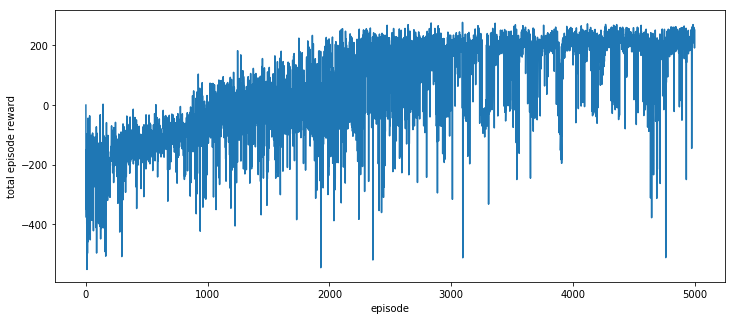

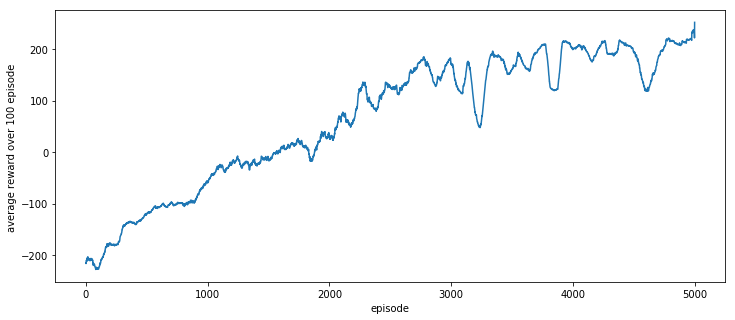

In [2]:
import pickle
#plot_cost_history(reward_history,'his')
#plot_cost_history(avg_reward(reward_history),'avg')
#with open('total_reward_lunar3', 'wb') as fp:
 #   pickle.dump(reward_history, fp)
with open ('total_reward_lunar', 'rb') as fp:
    his = pickle.load(fp)
average=avg_reward(his)
plot_cost_history(his,'his')
plot_cost_history(average,'avg')